# k-Nearest Neighbor (kNN)

*Work through the KNN classifier to gain an understanding of how the classifier works, how it is implemented and how the hyperparameters affect its performance. Use the results in your exam report.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is a hyperparameter and is cross-validated

In this exercise you will get an understanding of the basic Image Classification pipeline, cross-validation, and learn about efficient, vectorized code.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Run some setup code for this notebook.

import sys
sys.path.append('/content/drive/My Drive/Deep_Learning/cs231n')
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import time

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = '/content/drive/My Drive/Deep_Learning/cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


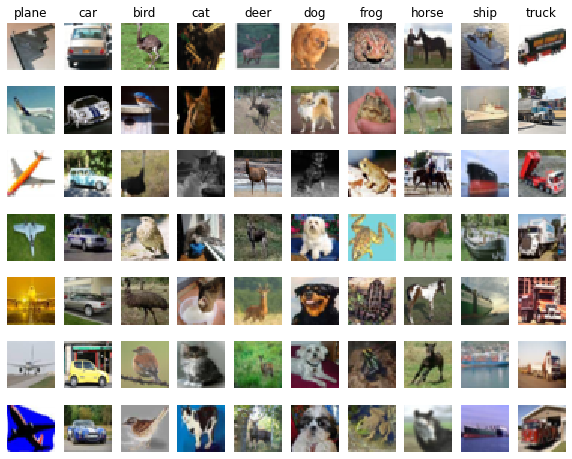

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Subsample the data for more efficient code execution in this exercise
num_training = 10000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]
print(X_train.shape, X_test.shape)

# Reshape the image data into rows (flattening)
X_train = np.reshape(X_train, (X_train.shape[0], -1)) #order of -1 tells Numpy to figure the remaining of the shape out by itself (magic!)
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(10000, 32, 32, 3) (500, 32, 32, 3)
(10000, 3072) (500, 3072)


In [ ]:
from classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
t1 = time.time()
classifier.train(X_train, y_train)
t2 = time.time()
print(t2-t1)

5.1975250244140625e-05


We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

The distance calculation is implemented in the function `compute_distances_two_loops` in the file `cs231n/classifiers/k_nearest_neighbor.py`. This implementation uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [ ]:
# Test the implementation:
t1 = time.time()
dists = classifier.compute_distances_two_loops(X_test)
t2 = time.time()
print(dists.shape)
print(t2-t1)

(500, 10000)
74.72522068023682


**Inline Questions Part 1** 

We would like for you to record the time it takes for the kNN-classifier to train and classify the test data (with compute_distances_two_loops) with a couple different training- and test-data sizes. (You will need to reload the data in one of the cells above and then change num_training and num_test before subsampling)

- $\color{yellow}{\text{How does the size of the training set affect the training time? }}$
- $\color{yellow}{\text{How does the size of the test set & training set affect the test time?}}$ 
- $\color{yellow}{\text{Can you explain this with your theoretical knowledge about - the kNN-classifier?}}$ <br>
$\color{green}{\textit Your Answer:}$ <br>
Test 1: (500, 5000)  - time: 39.8s  <br>
Test 2: (1000, 5000) - time: 86,5s  <br>
Test 3: (200, 5000)  - time: 18.58s <br>
Test 4: (500, 3000)  - time: 22.32s <br>
Test 5: (500, 8000)  - time: 58.83s <br> <br>
As either the test or traning kernel increases the more points have to be plotted which increases time the operation takes.<br>
Solely the training set size increases the width of the plot below which is a lot more operations than if the test kernel was increased.<br> <br>

  Increasing both will both increase the plot in width and height and operation time increases significantly. <br> <br>

  As you increase the kernel in which we look for the same images, it has more images to look through before making a decision on which is the best match. This means increased iteration time and if it has to do multiple loops this time is increased with the same big O notation multiple times. (quick guess)

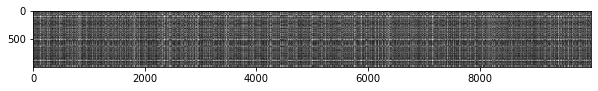

In [ ]:
# We can visualize the distance matrix.
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Questions Part 2** 

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- $\color{yellow}{\text{Euclidean distance matrix: }}$

  In distance matrices, the distances are defined directly and not their squares. In the Euclidean case, squares are used to avoid computing square roots and simplify algorithms.  

- $\color{yellow}{\text{What is on the x-axis?}}$
  
  The number of training images.

- $\color{yellow}{\text{What is on the y-axis?}}$

  The number of test images

- $\color{yellow}{\text{What in the data is the cause behind the distinctly bright rows?}}$

  Well, looking at what the method does in k_nearest_neighbour.py in the classifier folder, it creates an array of the euclidean distance between the i'th test point and j'th training point.

  And since the pictures are flatterend to a single array each i in the test array would hit the same j in the traning array. For each i'th element the distance matrix creates a row with distances to each j'th element in the traning array.

  Therefore none of the points in the test array's i'th point matches the traning array's j'th point.

- $\color{yellow}{\text{What causes the distinctly bright columns?}}$

  Opposite to the previous question, the test point at the i'th index does not match any of the training points in the entire traning array.

- $\color{yellow}{\text{What can you use this information for?}}$

  In a distance matrix the table shows the distance between pairs of objects.
  A distance matrix is good since it reduces the dimensionality and using a semidefinite matrix we can efficiently solve euclidean matrices.
  Semidefinite means that for any i * j element, the data is nonnegative.




In [ ]:
# Take a look at the implementation of the function 'predict_labels' in the file 'cs231n/classifiers/k_nearest_neighbor.py' and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [ ]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

You should expect to see a slightly better performance than with `k = 1`.

**Inline Questions Part 3**

- Why does the performance change with different values of k?
- What is happening inside the 'predict_labels' function?

$\color{green}{\textit Your Answer:}$ *fill this in.*


In [ ]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. This is implemented in the function 'compute_distances_one_loop'. 
# Run the code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

In [ ]:
# We can speed up the distance matrix computation even more by implementing a fully vectorized version. This is done inside 'compute_distances_no_loops'. Check it out!
# Run the code:
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

In [ ]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, you might not see a speedup when you go from two loops to one loop, and might even see a slow-down.

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

TODO: 
- Choose a set of values for k to use in the cross-validation test (e.g. [1, 3, 5, 8, 10, 12, 15, 20, 50, 100])
- Good practice is to start with a wide range of values for your hyperparameter, and gradually narrow it down.

In [ ]:
num_folds = 5
k_choices = [] #TODO: Choose a set of values for k to use in the cross-validation test

X_train_folds = []
y_train_folds = []

################################################################################
# What we do:                                                                  #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
################################################################################

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

################################################################################
# What we do:                                                                  #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################

for k_val in k_choices:
    k_to_accuracies[k_val] = []
    for i in range(num_folds):
        classifier = KNearestNeighbor()  # We reinitialize our classifier for each fold, so that it does not carry any "memory" over from previous folds
        training_data = np.concatenate([ fold for j, fold in enumerate(X_train_folds) if i != j ])  # Our training folds are all the folds except i
        training_data_labels = np.concatenate([ fold for j, fold in enumerate(y_train_folds) if i != j ]) # Same for our labels
        classifier.train(training_data, training_data_labels)

        y_test_pred = classifier.predict(X_train_folds[i], k=k_val)  # The only fold used to evaluate the performance is fold i
        
        # Compute and print the fraction of correctly predicted examples
        num_correct = np.sum(y_test_pred == y_train_folds[i])
        accuracy = float(num_correct) / X_train_folds[i].shape[0]
        k_to_accuracies[k_val].append(accuracy)

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.

best_k = # TODO: Set the value of k which performed best in your cross-validation test

# Reshape the image data into rows (flattening)
X_train = np.reshape(X_train, (X_train.shape[0], -1)) #order of -1 tells Numpy to figure the remaining of the shape out by itself (magic!)
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

num_test = X_test.shape[0]

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

**Inline Questions Part 4**

- How did you structure your search for the best value of k?
- What did you find? Comment on your graph.
- What is your explanation for the performance of really low values of k and really high values of k (e.g. k = number of training samples)?
- What happens if the k-nearest neighbors contain an equal number of two or more different classes?
- Why do we mainly care about the validation- / test accuracy?
- What would happen if you tried to use kNN with k=1 to classify the training data?

$\color{green}{\textit Your Answer:}$ *fill this in.*

